In [2]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm as WN
from torch.optim.lr_scheduler import MultiStepLR, StepLR,ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from ipywidgets import interact
types=torch.float64
torch.set_default_dtype(types)

In [68]:
class PDE_with_boundary_square_inside():
    """Class for solving a PDE with Neumann and Dirichlet conditions using DGM"""
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.total_time=eqn_config["total_time"]
        self.lambd = 4.0
        self.nu=0.05
        self.F=5.0
        self.pLeft=[0.333333333,0.2]
        self.pRigth=[0.66666666,0.8]
        self.pInf=0.4
        self.pAnc=0.2
        self.width=self.pRigth[0]-self.pLeft[0]
        self.heigth=self.pRigth[1]-self.pLeft[1]
        self.area=self.width*self.heigth
        self.areaMov=1-self.area
        self.model=ResNetLikeDGM(3,1)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001,weight_decay=0.00001)
        self.scheduler2 = StepLR(self.optimizer,step_size=1500,gamma=0.9)
        #self.scheduler=ReduceLROnPlateau(self.optimizer, 'min',factor=0.9,threshold=1e-3,patience=100)
        self.Nsamp=512
        self.interior_valid = self.interior_sample(512)
        self.neumann_valid= self.neumann_sample(512)
        self.dirichlet_valid=self.dirichlet_sample(512)
        self.terminal_valid=self.terminal_sample(512)
        self.currEps=0
    
    def is_inside(self,X):
        x=X[0]
        if x[0]<self.pRigth[0] and x[0]>self.pLeft[0] and x[1]>self.pLeft[1] and x[1]<self.pRigth[0]:
            return True
        return False
    
    def set_lr(self,lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr
        
        
    def interior_sample(self,num_sample):
        niz=int(num_sample*self.pLeft[0]/self.areaMov)
        nder=int(num_sample*(1.0-self.pRigth[0])/self.areaMov)
        nup=int(num_sample*(self.width*(1-self.pRigth[1]))/self.areaMov)
        ndown=int(num_sample*(self.width*(self.pLeft[1]))/self.areaMov)
        
        xiz=np.random.uniform(size=niz)*self.pLeft[0]
        yiz=np.random.uniform(size=niz)
        tiz=np.random.uniform(low=0,high=self.total_time,size=niz)
        xder=np.random.uniform(size=nder)*(1-self.pRigth[0])+self.pRigth[0]
        yder=np.random.uniform(size=nder)
        tder=np.random.uniform(low=0,high=self.total_time,size=nder)
        xup=np.random.uniform(size=nup)*self.width +self.pLeft[0]
        yup=np.random.uniform(size=nup)*(1-self.pRigth[1])+self.pRigth[1]
        tup=np.random.uniform(low=0,high=self.total_time,size=nup)
        xdw=np.random.uniform(size=ndown)*self.width+self.pLeft[0]
        ydw=np.random.uniform(size=ndown)*self.pLeft[1]
        tdw=np.random.uniform(low=0,high=self.total_time,size=ndown)
        iz=np.column_stack((tiz,xiz,yiz))
        der=np.column_stack((tder,xder,yder))
        up=np.column_stack((tup,xup,yup))
        down=np.column_stack((tdw,xdw,ydw))
        #return torch.tensor(np.hstack((t,x)),requires_grad=True)
        return torch.tensor(np.concatenate((iz,der,up,down)),requires_grad=True)
    
    def dirichlet_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.stack((np.ones(num_sample),self.pInf+np.random.uniform(size=num_sample)*self.pAnc),axis=1)
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def neumann_exterior_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((np.zeros(Ns),np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[-1.0,0.0]],Ns,0)
        up=np.stack((np.random.uniform(size=Ns),np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,1.0]],Ns,0)
        down=np.stack((np.random.uniform(size=Ns),np.zeros(Ns)),axis=1)
        ndown=np.repeat([[0.0,-1.0]],Ns,0)
        der1=np.stack((np.ones(int(Ns/2)),self.pInf+self.pAnc+np.random.uniform(size=int(Ns/2))*(1-self.pInf-self.pAnc)),axis=1)
        nder1=np.repeat([[1.0,0.0]],int(Ns/2),0)
        der2=np.stack((np.ones(int(Ns/2)),np.random.uniform(size=int(Ns/2))*self.pInf),axis=1)
        nder2=np.repeat([[1.0,0.0]],int(Ns/2),0)
        x=np.concatenate((iz,up,down,der1,der2))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return np.hstack((t,x)),np.concatenate((niz,nup,ndown,nder1,nder2))
    
    def neumann_interior_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((self.pLeft[0]*np.ones(Ns),self.pLeft[1]+self.heigth*np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[1.0,0.0]],Ns,0)
        up=np.stack((self.pLeft[0]+self.width*np.random.uniform(size=Ns),self.pRigth[1]*np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,-1.0]],Ns,0)
        down=np.stack((self.pLeft[0]+self.width*np.random.uniform(size=Ns),self.pLeft[1]*np.ones(Ns)),axis=1)
        ndown=np.repeat([[0.0,1.0]],Ns,0)
        der=np.stack((self.pRigth[0]*np.ones(Ns),self.pLeft[1]+self.heigth*np.random.uniform(size=Ns)),axis=1)
        nder=np.repeat([[-1.0,0.0]],Ns,0)
        x=np.concatenate((iz,up,down,der))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return np.hstack((t,x)),np.concatenate((niz,nup,ndown,nder))
    
    def neumann_sample(self,num_sample):
        p=(2*self.width+2*self.heigth)/3.8
        x1,n1=self.neumann_exterior_sample(int(num_sample*(1-p)))
        x2,n2=self.neumann_interior_sample(int(num_sample*p))
        return torch.tensor(np.concatenate((x1,x2)),requires_grad=True),torch.tensor(np.concatenate((n1,n2)))
    
    def terminal_sample(self,num_sample):
        niz=int(num_sample*self.pLeft[0]/self.areaMov)
        nder=int(num_sample*(1.0-self.pRigth[0])/self.areaMov)
        nup=int(num_sample*(self.width*(1-self.pRigth[1]))/self.areaMov)
        ndown=int(num_sample*(self.width*(self.pLeft[1]))/self.areaMov)
        
        xiz=np.random.uniform(size=niz)*self.pLeft[0]
        yiz=np.random.uniform(size=niz)
        tiz=np.ones(shape=[niz,1])*self.total_time
        xder=np.random.uniform(size=nder)*(1-self.pRigth[0])+self.pRigth[0]
        yder=np.random.uniform(size=nder)
        tder=np.ones(shape=[nder,1])*self.total_time
        xup=np.random.uniform(size=nup)*self.width +self.pLeft[0]
        yup=np.random.uniform(size=nup)*(1-self.pRigth[1])+self.pRigth[1]
        tup=np.ones(shape=[nup,1])*self.total_time
        xdw=np.random.uniform(size=ndown)*self.width+self.pLeft[0]
        ydw=np.random.uniform(size=ndown)*self.pLeft[1]
        tdw=np.ones(shape=[ndown,1])*self.total_time
        iz=np.column_stack((tiz,xiz,yiz))
        der=np.column_stack((tder,xder,yder))
        up=np.column_stack((tup,xup,yup))
        down=np.column_stack((tdw,xdw,ydw))
        return torch.tensor(np.concatenate((iz,der,up,down)),requires_grad=True)
        
    def loss(self,interior_sample,neumann_sample,dirichlet_sample,terminal_sample):
        
        V=self.model(interior_sample)
        dV=torch.autograd.grad(V,interior_sample, grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_t=dV[:,0]
        V_x=dV[:,1:]
        V_xx=torch.autograd.grad(dV,interior_sample,grad_outputs=torch.ones_like(dV),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1:]
        diff_V=self.Lv(interior_sample, V_t,V_x,V_xx)
        L1=torch.mean(torch.square(diff_V))
        
        x_neumann,n_neumann=neumann_sample
        Vn=self.model(x_neumann)
        dVn=torch.autograd.grad(Vn,x_neumann, grad_outputs=torch.ones_like(Vn),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_nx=dVn[:,1:]
        normaldVn=torch.sum(V_nx*n_neumann,axis=1)
        L2=torch.mean(torch.square(normaldVn-self.h_n(x_neumann)))
        
        Vd=self.model(dirichlet_sample)
        L3=torch.mean(torch.square(Vd-self.h_d(dirichlet_sample)))
        
        Vter=self.model(terminal_sample)
        L4=torch.mean(torch.square(Vter-self.g_Tf(terminal_sample)))
        
        #print("L1: ",L1," L2: ",L2," L3: ",L3," L4: ",L4)
        return L1,L2,L3,L4
    
    def h_n(self,x):
        """Neumann boundary condition"""
        return torch.zeros(x.shape[0])
    
    def h_d(self,x):
        """Dirichlet boundary condition"""
        return -0.0*torch.ones(x.shape[0])
    
    def g_Tf(self,x):
        """Terminal condition"""
        #lens=x[:,1:]-torch.tensor(np.repeat([[1.0,0.05]],x.shape[0],0))
        return torch.zeros(x.shape[0])
        #return torch.sqrt(torch.sum(lens*lens,axis=1))
        
    def Lv(self, x, V_t,V_x,V_xx):
        return V_t+self.nu*torch.sum(V_xx,axis=1)-self.lambd*torch.sum(V_x*V_x,axis=1)+self.F
    
    def train(self,Nsteps):
        start_time = time.time()
        training_history = []

        # begin sgd iteration
        for step in range(Nsteps+1):
            #print(step)
            interior = self.interior_sample(self.Nsamp)
            neumann= self.neumann_sample(self.Nsamp)
            dirichlet=self.dirichlet_sample(self.Nsamp)
            terminal=self.terminal_sample(self.Nsamp)
            L1,L2,L3,L4=self.loss(interior,neumann,dirichlet,terminal)
            L=5*L1+L2+10*L3+10*L4
            self.optimizer.zero_grad(set_to_none=True)
            L.backward()
            self.optimizer.step()
            #self.scheduler.step(loss)
            #self.scheduler2.step()
            
            
            if step % 200==0:
                
                L1,L2,L3,L4 = self.loss(self.interior_valid,self.neumann_valid,self.dirichlet_valid,self.terminal_valid)
                L=0.3*L1+0.1*L2+0.3*L3+0.3*L4
                loss=L.detach().numpy()
                #y_init = self.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, elapsed_time])
                print("Epoch ",self.currEps," time ", elapsed_time," loss ", loss, "L1:", L1," L2:", L2," L3: ", L3," L4: ", L4)
            self.currEps+=1

        return np.array(training_history)
    def control(self,t,X):
        pos=torch.tensor(np.hstack((t,X)),requires_grad=True)
        u=self.model(pos)
        alpha=-np.sqrt(self.lambd)*torch.autograd.grad(u,pos)[0][1:]
        return alpha.detach().numpy()
    def save_model(self,file_name):
        torch.save(self.model.state_dict(), file_name)
    def load_model(self,file_name):
        self.model.load_state_dict(torch.load(file_name))

In [69]:

sigma = torch.tanh

class DGMCell(nn.Module):
    def __init__(self, d, M, growing, weight_norm):
        super().__init__()
        wn = WN if weight_norm else lambda x: x

        self.Uz = wn(nn.Linear(d, M, bias=False))
        self.Ug = wn(nn.Linear(d, M, bias=False))
        self.Ur = wn(nn.Linear(d, M, bias=False))
        self.Uh = wn(nn.Linear(d, M, bias=False))

        self.Wz = wn(nn.Linear(M, M))
        self.Wg = wn(nn.Linear(M, M))
        self.Wr = wn(nn.Linear(M, M))
        self.Wh = wn(nn.Linear(M, M))

        self.A = (lambda x: x) if growing else sigma

    def forward(self, SX):
        S, X = SX
        Z = sigma(self.Uz(X) + self.Wz(S))
        G = sigma(self.Ug(X) + self.Wg(S))
        R = sigma(self.Ur(X) + self.Wr(S))
        H = self.A(self.Uh(X) + self.Wh(S*R))
        S = (1-G)*H + Z*S

        return S, X


def _set_convert(flag):
    if flag: return lambda X: X[0]
    return lambda X: torch.stack(X, -1)


class ResNetLikeDGM(nn.Module):
    """
    DGM algorithm from https://arxiv.org/pdf/1708.07469.pdf
    Args:
    -----
    d_in and d_out- input and ouput dimensions of the problem
    M - layers' width
    L - recurrency depth
    """
    def __init__(
            self, d_in, d_out, M=50, L=3,
            growing=False, as_array=True, weight_norm=False):
        super().__init__()
        wn = WN if weight_norm else lambda x: x
        self.W0 = wn(nn.Linear(d_in, M))
        self.W1 = wn(nn.Linear(M, d_out))
        self._convert = _set_convert(as_array)

        self.layers = []
        for l in range(L):
            self.layers.append(DGMCell(d_in, M, growing, weight_norm))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, *X):
        X = self._convert(X)
        S = sigma(self.W0(X))
        S,_ = self.layers((S, X))
        return self.W1(S).squeeze_(-1)


In [70]:
pde=PDE_with_boundary_square_inside({"dim":2,"total_time":1.0,"Ndis":20})

In [59]:
pde.optimizer.param_groups[0]["lr"]

0.001

In [36]:
pde.optimizer.param_groups[0]["lr"]=1e-4

In [71]:
trainings=[]

In [74]:
trainings.append(pde.train(1000))

Epoch  3001  time  0.09586930274963379  loss  0.05945195073954948 L1: tensor(0.0082, grad_fn=<MeanBackward0>)  L2: tensor(0.5492, grad_fn=<MeanBackward0>)  L3:  tensor(0.0025, grad_fn=<MeanBackward0>)  L4:  tensor(0.0044, grad_fn=<MeanBackward0>)
Epoch  3201  time  10.654016017913818  loss  0.05777750267503589 L1: tensor(0.0094, grad_fn=<MeanBackward0>)  L2: tensor(0.5288, grad_fn=<MeanBackward0>)  L3:  tensor(0.0021, grad_fn=<MeanBackward0>)  L4:  tensor(0.0048, grad_fn=<MeanBackward0>)
Epoch  3401  time  20.794254779815674  loss  0.05644257280790871 L1: tensor(0.0078, grad_fn=<MeanBackward0>)  L2: tensor(0.5210, grad_fn=<MeanBackward0>)  L3:  tensor(0.0015, grad_fn=<MeanBackward0>)  L4:  tensor(0.0052, grad_fn=<MeanBackward0>)
Epoch  3601  time  31.52057719230652  loss  0.05493949293406207 L1: tensor(0.0062, grad_fn=<MeanBackward0>)  L2: tensor(0.5122, grad_fn=<MeanBackward0>)  L3:  tensor(0.0017, grad_fn=<MeanBackward0>)  L4:  tensor(0.0045, grad_fn=<MeanBackward0>)
Epoch  3801  tim

In [47]:
sp,sn=pde.neumann_sample(10000)
sd=pde.dirichlet_sample(1000)
ints=pde.interior_sample(2048)

In [48]:
sp=sp.detach().numpy()
sd=sd.detach().numpy()
ints=ints.detach().numpy()

(-0.05, 1.05, -0.05, 1.05)

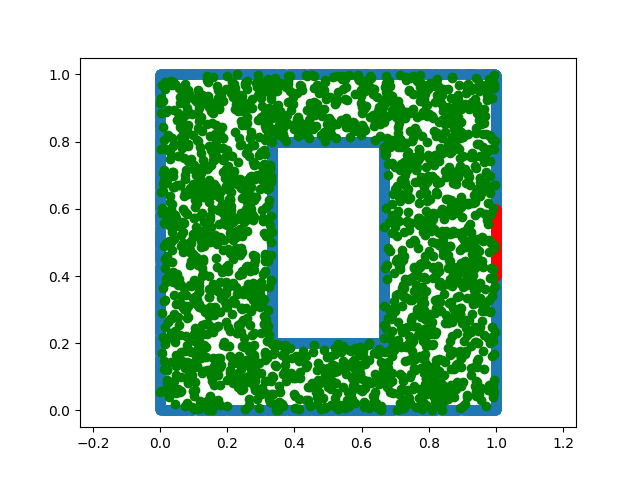

In [49]:
plt.figure()
plt.scatter(sp[:,1],sp[:,2])
plt.scatter(sd[:,1],sd[:,2],color='r')
plt.scatter(ints[:,1],ints[:,2],color='g')
plt.axis('equal')

In [ ]:
def proyectar_adentro(X,pde):
    x=X[0]
    y=X[1]
    if x<0.0:
        x=0.0
    elif x>1.0:
        x=1.0
    if y<0:
        y=0.0
    elif y>1.0:
        y=1.0
    elif x>pde.pLeft[0] and x<pde.pRigth[0] and y>pde.pLeft[1] and y<pde.pRigth[1]:
        n=np.argmin([x-pde.pLeft[0],pde.pRigth[0]-x,y-pde.pLeft[1],pde.pRigth[1]-y])
        if n==0:
            x=pde.pLeft[0]
        elif n==1:
            x=pde.pRigth[0]
        elif n==2:
            y=pde.pLeft[1]
        elif n==3:
            y=pde.pRigth[1]
    return [x,y]

def control_posible(t,X):
    n=np.array([1.0-X[0],0.5-X[1]])
    return n/np.linalg.norm(n)
def simular_trayectoria(control,dt,Tf,X0,lam,nu,pde,proyectar):
    N=int(Tf/dt)
    Xis=np.random.normal(loc=0,scale=np.sqrt(dt),size=(N,2))
    X=np.zeros((N,2))
    X[0]=X0
    t=0
    for i in range(1,Xis.shape[0]):
        n=control(t,X[i-1])
        X[i][0]=X[i-1][0]+2*np.sqrt(lam)*(n[0])*dt+np.sqrt(2*nu)*Xis[i][0]
        X[i][1]=X[i-1][1]+2*np.sqrt(lam)*(n[1])*dt+np.sqrt(2*nu)*Xis[i][1]
        if proyectar:
            X[i]=proyectar_adentro(X[i],pde)
        t+=dt
    return X

In [ ]:
dt=0.001
Tf=1.0
X0=[0.2,0.5]
lam=pde.lambd
nu=pde.nu
X=simular_trayectoria(pde.control,dt,Tf,X0,lam,nu,pde,True)
plt.figure()
plt.cla()
plt.plot(X[:,0],X[:,1])
rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((pde.pLeft[0], pde.pLeft[1]), pde.width, pde.heigth, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.gca().add_patch(rect2)
plt.xlim((-0.2,1.2))
plt.ylim((-0.2,1.2))
plt.axis('equal')
plt.show()
plt.grid()

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.draw(t)>

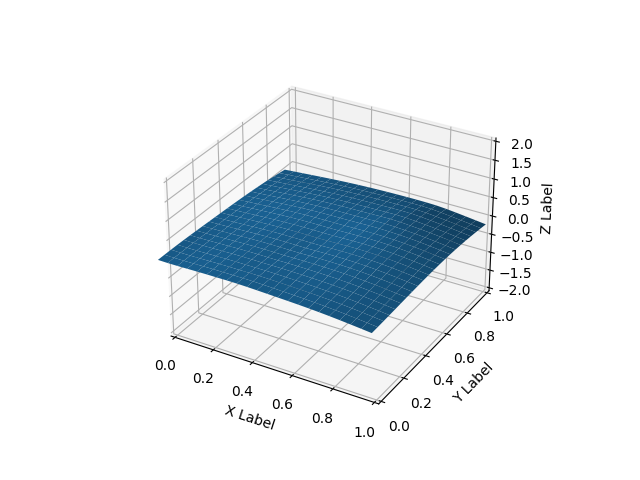

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-0.05, 1.05, 0.05)
X, Y = np.meshgrid(x, y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-5,5)

def draw(t):  
    ax.cla()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(-2,2)
    times=t*np.ones(np.ravel(X).shape[0])
    tes=torch.tensor(np.stack((times,np.ravel(X), np.ravel(Y)),axis=1))
    zs =pde.model(tes).detach().numpy()
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)

interact(draw,t=widgets.FloatSlider(min=0, max=1.0, step=0.01, value=10))


In [ ]:
x = y = np.arange(-0.05, 1.05, 0.05)
mask = ~((X < pde.pRigth[0]) & (X > pde.pLeft[0]) & (Y < pde.pRigth[1]) & (Y > pde.pLeft[1]))
X, Y = np.meshgrid(x, y)
X

In [ ]:
X[mask].reshape((22,22))

In [ ]:
mask = ~((X < pde.pRigth[0]) & (X > pde.pLeft[0]) & (Y < pde.pRigth[1]) & (Y > pde.pLeft[1]))
np.c_[X[mask], Y[mask]].shape